In [9]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from collections import OrderedDict
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
import torch
import re
from sdv.metadata import SingleTableMetadata


class Generator:

    def __init__(self, data, architecture, n_samples, n_epochs=None, categorical_columns=None, sensitive_columns=None):

        """
        :param n_epochs: the number of epochs used for training
        :param n_samples: the number of rows to generate
        :param architecture: the chosen architecture, one of ['CTGAN', 'GaussianCopula']
        :param data: the data that should be trained on, should be in a pandas dataframe
        :param categorical_columns: a list with categorical columns
        :param sensitive_columns: a dict with sensitive columns and what  category they belong to
        The categories can be found in the faker_categorical function

        The metadata: an sdv metadata object required to call CTGAN and other methods
        Also required for similarity checks
        """

        self.n_epochs = n_epochs
        self.n_samples = n_samples
        if architecture in ['CTGAN', 'GaussianCopula']:
            self.architecture = architecture
        else:
            print('The requested architecture is not available')
            raise ValueError
        print('Retrieving metadata, check with generator.metadata')
        self.data = data
        self.metadata = self.create_metadata()
        self.categorical_columns = categorical_columns
        self.sensitive_columns = sensitive_columns

    def create_metadata(self):
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=self.data)
        return metadata

    def generate(self):
        """
        Based on the chosen architecture, this function returns synthetically generated data
        :return: synthetic data, a pandas dataframe
        """

        #  TODO: Add more generators, especially PATEGAN or other differentially private ones synthcity seems to have
        #  implementations of these, but I have not been able to import their library

        if self.architecture == "CTGAN":
            model = CTGANSynthesizer(metadata=self.metadata, epochs=self.n_epochs, verbose=True)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)

        elif self.architecture == "GaussianCopula":
            model = GaussianCopulaSynthesizer(metadata=self.metadata)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)

        return synth_data

    def faker_categorical(self, seed=None):
        """
        Instantiates Faker, generates fake data for it
        WARNING: data generated here should not be used for ML models
        :param seed: int, random seed, defaults
        """

        # TODO: Find a way to make this generalizable, f.e. create many attributes, and return the ones asked

        seed = seed or random.seed()
        # We can initialize the faker with multiple locations: can now draw addresses and names from
        # Germany, US, UK, Spain, France, Italy. Either just a list => all equal weights, or an ordered
        # dictionary in which weights can be specified.
        locale_list = ['de_DE', 'en_US', 'en_GB', 'es_ES', 'fr_FR', 'it_IT']
        fake = Faker(locale_list)
        fake.seed_instance(seed)
        # check whether the ID generated is already in use
        used_ids = set()
        output = []
        for i in range(self.n_samples):
            # select a locale at random => will allow us to generate internally consistent city-country pairs
            # or name/email pairs. Problem is that not all countries might be able to generate all of these
            # attributes. For example Belgium can't create IP-addresses
            locale = np.random.choice(locale_list)
            while True:
                new_id = fake.random_int(min=1, max=self.n_samples)
                if new_id not in used_ids:
                    used_ids.add(new_id)
                    break

            gender = np.random.choice(["Male", "Female"], p=[0.5, 0.5])
            # this works, but it's technical debt, talk to Léo about it
            if gender == "male":
                first_name = fake[locale].first_name_male()
            else:
                first_name = fake[locale].first_name_female()
            last_name = fake[locale].last_name()
            row = {
                "id": new_id,
                "first_name": first_name,
                "last_name": last_name,
                # take everything before @, and replace with first name.lastname
                "email": re.sub(r'^(.*?)@', first_name + "." + last_name + "@", fake[locale].free_email()),
                "gender": gender,
                "ip_address": fake[locale].ipv4_private(),
                "nationality": fake[locale].current_country(),
                "city": fake[locale].city()
            }
            output.append(row)

        df = pd.DataFrame(output, columns=self.sensitive_columns)
        return df

In [24]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from table_evaluator import TableEvaluator
from sdv.evaluation.single_table import evaluate_quality

# TODO: ML model performance and test correlation

#############
# The quality report needs metadata
# sdv can deduce this from the dataframe, but it does not yet work on my computer
# from sdv.metadata import SingleTableMetadata
# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(data=my_pandas_dataframe)


class SimilarityCheck:

    '''
    Check the quality of the synthetic data both visually and with metrics
    '''

    def __init__(self, real_data, synthetic_data, cat_cols, metadata):
        self.real_data = real_data
        self.synthetic_data = synthetic_data
        if cat_cols is not None:
          self.cat_cols = cat_cols
        else:
          self.cat_cols = []
        self.metadata = metadata
        ############
        # We can immediately call the functions upon initialization
        self.visual_comparison_columns()
        #self.comparison_columns()

    #def check_similarity(self):
      #  evaluator = TableEvaluator(real=self.real_data, fake=self.synthetic_data, cat_cols=self.cat_cols)
      #  evaluator.visual_evaluation()

    def comparison_columns(self):
        '''
        :return: the KL divergence for numerical variables...
        tested and works
        '''
        quality_report = evaluate_quality(
          real_data=self.real_data,
          synthetic_data=self.synthetic_data,
          metadata=self.metadata)

        #report = QualityReport()
        #print(report.generate(self.real_data, self.synthetic_data, self.metadata))
        #print(report.get_details(property_name='Column Shapes')


    def visual_comparison_columns(self):
        '''
        Plot data in one of three ways:
        1) numeric columns are plotted using the densities
        2) categorical columns with limited categories are ideally plotted with a bar: find a way to put them
        next to each other, potentially by making one big df and using 'hue'
        3)
        :return:
        '''
        if (self.real_data.columns != self.synthetic_data.columns).all():
            print('Columns in real and synthetic data not the same!')
            return

        fig, ax = plt.subplots(nrows=len(self.real_data.columns), figsize=(len(self.real_data.columns), len(self.real_data.columns)*3))

        for i, column in enumerate(self.real_data.columns):
            if column not in self.cat_cols:
                sns.kdeplot(self.real_data[column], ax=ax[i], label='Real', fill=True, color='c')
                sns.kdeplot(self.synthetic_data[column], ax=ax[i], label='Synthetic', fill=True, color='m')
            elif len(self.real_data[column].unique()) <= 5:
                sns.histplot(data = self.real_data,x = column, ax=ax[i],bins = len(self.real_data[column].unique()), label='Real', stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], bins = len(self.real_data[column].unique()),label='Synthetic', stat = "density", color='m',discrete = False ,element = 'step')
            else:
                sns.histplot(data = self.real_data,x = column, ax=ax[i], label='Real', fill = False,stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], label='Synthetic', fill = False,stat = "density", color='m',discrete = False ,element = 'step')

            ax[i].set_title(f'Comparison of {column}')
            ax[i].autoscale_view()
            ax[i].set_xlabel(column)
            ax[i].legend()
        plt.show()

    def compare_correlations(self):
        '''
        Compare correlation matrices
        :return:
        '''
        fig, ax = plt.subplots(figsize=(len(self.real_data.columns)*3, (len(self.real_data.columns)*2)))
        diff_corr = abs(self.real_data.corr() - self.synthetic_data.corr())
        mask = np.tril(np.ones_like(diff_corr, dtype=bool))
        sns.heatmap(diff_corr, mask=mask)

    def compare_model_performance(self, fitted_model_real, fitted_model_synth, X_test, y_test):
        """
        Method that computes how close the scores of a model trained on the real vs. synthetic
        data are.
        """
        score_real = fitted_model_real.score(X_test, y_test)
        score_synth = fitted_model_synth.score(X_test, y_test)
        print(f"Score on real dataset: {score_real}\nScore on synthetic dataset: {score_synth}")
        return score_real, score_synth


In [5]:
data = pd.read_csv('Subsample_training.csv')

In [10]:
cat_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'Risk_Flag']
sensitive_cols = ["first_name", "last_name", "email", "gender", "ip_address", "nationality", "city"]


generator = Generator(n_epochs=1, n_samples=100, architecture='CTGAN',
                          data=data,
                          categorical_columns=cat_cols,
                          sensitive_columns=sensitive_cols)

Retrieving metadata, check with generator.metadata


In [12]:
synth_data = generator.generate().iloc[:, 2:]

Epoch 1, Loss G:  2.5901,Loss D: -0.0486


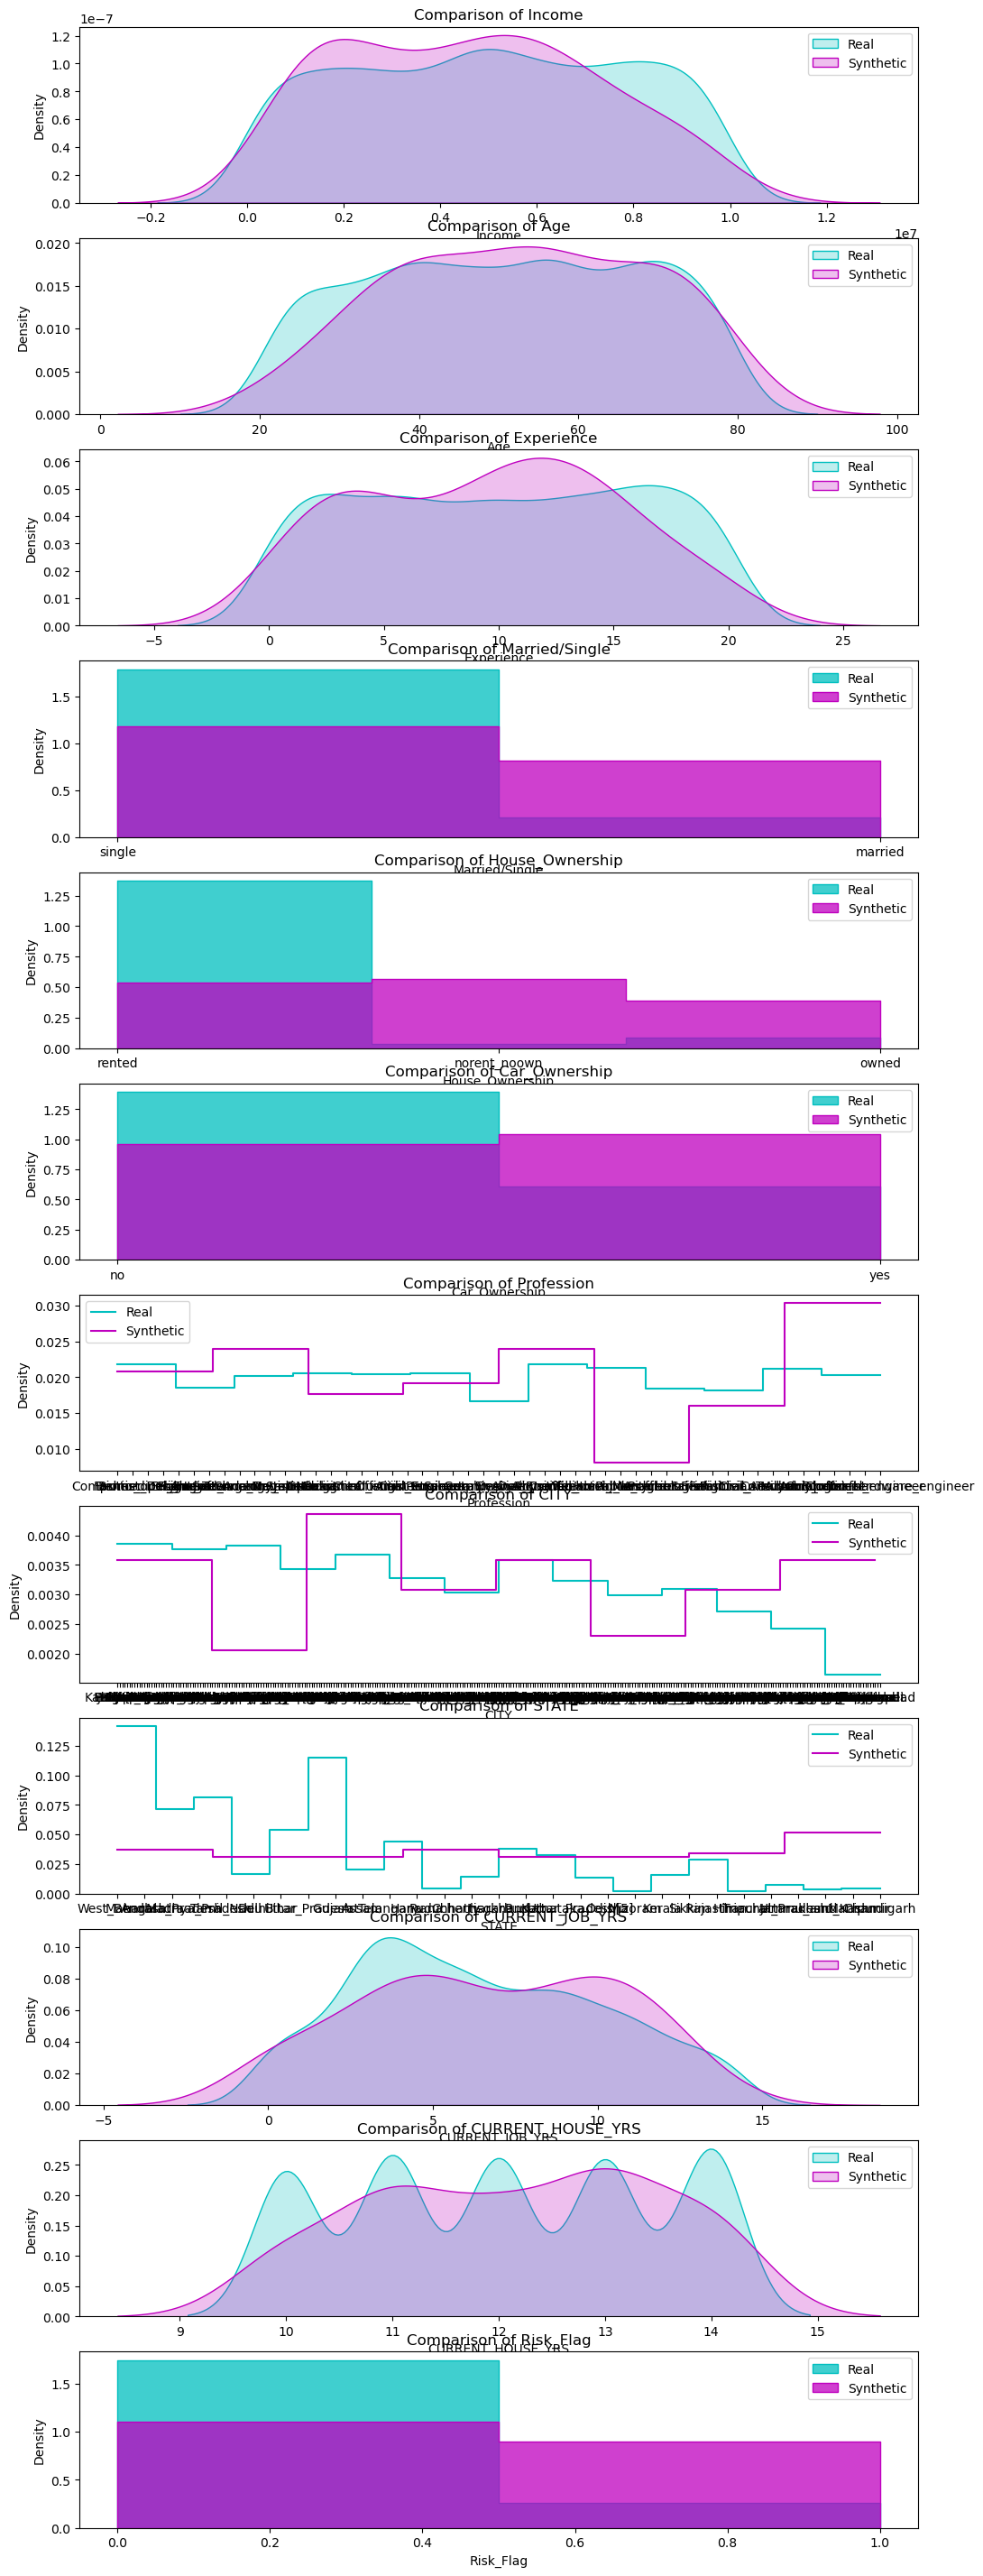

In [25]:
similarity_checker = SimilarityCheck(data.iloc[:, 2:], synth_data, cat_cols, generator.metadata)


In [26]:
from realtabformer import REaLTabFormer



# Non-relational or parent table.
rtf_model = REaLTabFormer(
    model_type="tabular",
    gradient_accumulation_steps=4,
    logging_steps=100)

# Fit the model on the dataset.
# Additional parameters can be
# passed to the `.fit` method.
rtf_model.fit(data.iloc[:, 2:])

# Save the model to the current directory.
# A new directory `rtf_model/` will be created.
# In it, a directory with the model's
# experiment id `idXXXX` will also be created
# where the artefacts of the model will be stored.
#rtf_model.save("rtf_model/")

# Generate synthetic data with the same
# number of observations as the real dataset.

# Load the saved model. The directory to the
# experiment must be provided.
#rtf_model2 = REaLTabFormer.load_from_dir(
   # path="rtf_model/idXXXX")

/opt/anaconda3/envs/CRP_GDPR_datasets/lib/python3.10/site-packages/realtabformer/realtabformer.py:76: UserWarning: The device=cuda is not available, using device=mps instead.
  warnings.warn(f"The device={device} is not available, using device={_device} instead.")
ate (0.0905) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/opt/anaconda3/envs/CRP_GDPR_datasets/lib/python3.10/site-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 16...
  warnings.warn(


Computing the sensitivity threshold...
Using parallel computation!!!


Bootstrap round: 100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


Sensitivity threshold summary:
count    500.000000
mean       0.021159
std        0.006741
min        0.002609
25%        0.016288
50%        0.021103
75%        0.025783
max        0.040193
dtype: float64
Sensitivity threshold: 0.03268485745432466 qt_max: 0.05


/opt/anaconda3/envs/CRP_GDPR_datasets/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,2.280500
200,1.749500
300,1.656000


  0%|          | 0/990 [00:00<?, ?it/s]/opt/anaconda3/envs/CRP_GDPR_datasets/lib/python3.10/site-packages/transformers/generation/utils.py:690: UserWarning: The operator 'aten::repeat_interleave.self_int' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740388473/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  input_ids = input_ids.repeat_interleave(expand_size, dim=0)
  0%|          | 0/990 [00:01<?, ?it/s]


NotImplementedError: The operator 'aten::cumsum.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [28]:
PYTORCH_ENABLE_MPS_FALLBACK=1

samples = rtf_model.sample(n_samples=len(data))

AssertionError: Torch not compiled with CUDA enabled

In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from collections import OrderedDict
from sdv.evaluation import evaluate
from table_evaluator import TableEvaluator
from src.utils import *
import re
from similarity_check.SimilarityCheck import *
from synthetic_data_generation.generator import *

if __name__ == "__main__":

    ##############################
    # Testing area
    ##############################

    # define path to the data you want to test
    path_test_data = "./Subsample_training.csv"

    # take the comment out to see the first 10 rows of your data

    # indicate which columns are categorical, and which are sensitive
    cat_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'Risk_Flag']
    sensitive_cols = ["first_name", "last_name", "email", "gender", "ip_address", "nationality", "city"]

    my_metadata = {
        'fields':
            {
                'Income': {'type': 'numerical', 'subtype': 'integer'},
                'Age': {'type': 'numerical', 'subtype': 'integer'},
                'Experience': {'type': 'numerical', 'subtype': 'integer'},
                'CURRENT_JOB_YRS': {'type': 'numerical', 'subtype': 'integer'},
                'CURRENT_HOUSE_YRS': {'type': 'numerical', 'subtype': 'integer'},
                'Married/Single': {'type': 'categorical'},
                'House_Ownership': {'type': 'categorical'},
                'Car_Ownership': {'type': 'categorical'},
                'Profession': {'type': 'categorical'},
                'CITY': {'type': 'categorical'},
                'STATE': {'type': 'categorical'},
                'Risk_Flag': {'type': 'boolean'}
            },
        'constraints': [],
        'model_kwargs': {},
        'name': None,
        'primary_key': None,
        'sequence_index': None,
        'entity_columns': [],
        'context_columns': []
    }

    data = get_data(path_test_data)
    # checking that it can deal with nan values
    data.iloc[3, 2] = float("nan")
    print(data.head())
    # create object
    generator = Generator(n_epochs=1, n_samples=100, architecture='CTGAN',
                          data=data,
                          categorical_columns=cat_cols,
                          sensitive_columns=sensitive_cols)
    print("Generating data")
    synth_data = generator.generate().iloc[:, 2:]
    anonymized_data = generator.faker_categorical()
    df = pd.concat([anonymized_data, synth_data], axis=1)
    print(df.columns)
    df.drop(['CITY', 'STATE'], inplace=True, axis=1)
    print(df.head())
    #df.to_csv('synth_data.csv')

    similarity_checker = SimilarityCheck(data.iloc[:, 2:], synth_data, cat_cols, my_metadata)

ModuleNotFoundError: No module named 'sdv.tabular'